In [1]:
%pylab inline

from sklearn import model_selection
from sklearn import linear_model
from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.preprocessing import PolynomialFeatures
import pandas as pd
import multiprocessing

Populating the interactive namespace from numpy and matplotlib


##### датасет для задачи регрессии Boston Housing, 

##### необходимо предсказать стоимость дома по 13 признакам.

In [2]:
data = datasets.load_boston()
df = pd.DataFrame(data.data)
df.columns = data.feature_names
y = data.target

In [3]:
print(data.DESCR[:1500])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

____________

##### 1. Исследовать данные. (1 балл)

нарисовать 13 картинок, которые покажут зависимость целевой переменной (таргета, игрека, y) от каждого из признаков.

Hint. используйте https://matplotlib.org/gallery/shapes_and_collections/scatter.html#sphx-glr-gallery-shapes-and-collections-scatter-py

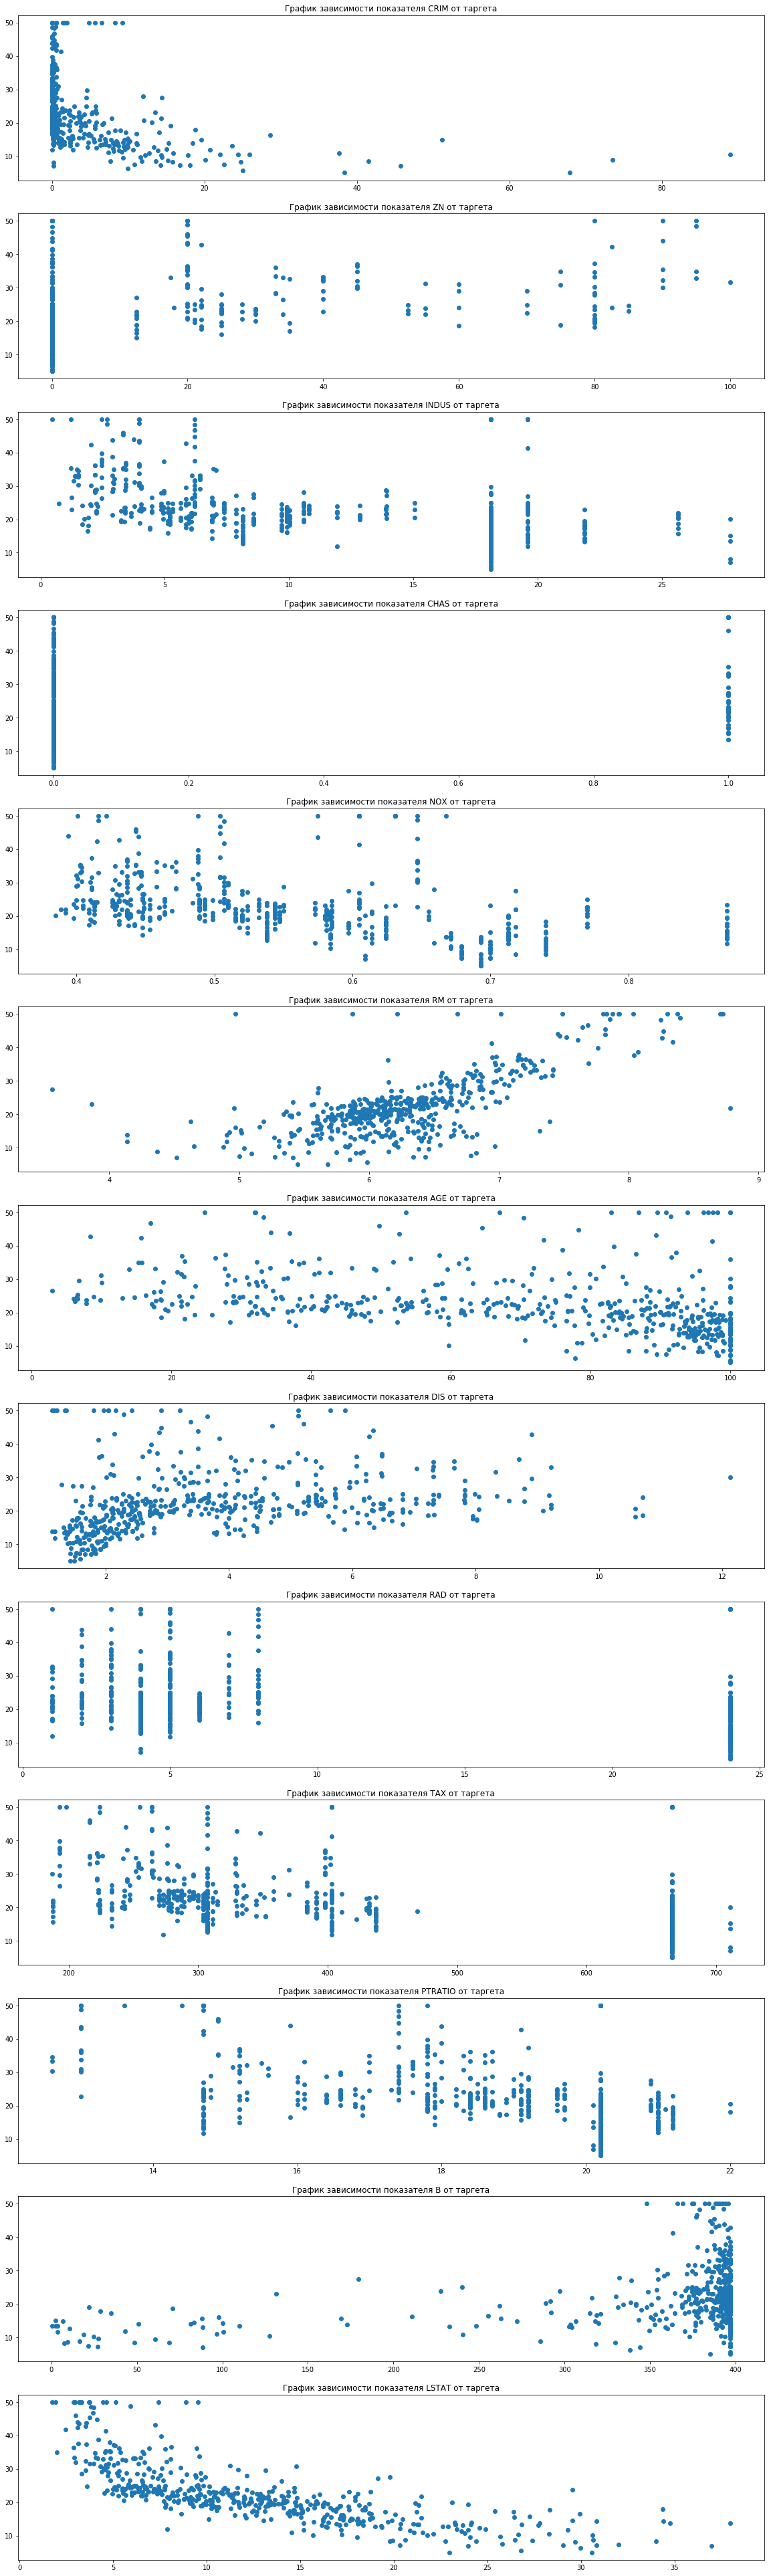

In [4]:
plt.figure(figsize=(20,70))
for i, column in enumerate(df.columns):
    plt.subplot(len(df.columns), 1, i + 1)
    plt.scatter(df[column], y)
    plt.title(f'График зависимости показателя {column} от таргета')

##### 2. Обучить регрессию. (1 балл)

Обучите любую линейную регрессию из sklearn. Померить качество на тестовой части по метрикам RMSE, R2.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df.values, y, test_size=0.2, random_state=42)
# не меняйте рандом стейт! - он поможет сделать вычисления воспроизводимыми

In [6]:
regressor = LinearRegression()

In [7]:
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [8]:
y_pred = regressor.predict(X_test)

In [9]:
np.sqrt(mean_squared_error(y_test, y_pred)), r2_score(y_test, y_pred)

(4.928602182665368, 0.6687594935356278)

##### 3. Сделайте крутую фичу. (1 балл)

Вернитесь к скатерплотам. Если вы правильно все построили - то вы увидите что один из признаков (LSTAT) как то зависит от y. Сделайте спрямляющее преобразование (добавьте новый признак) и обучите регрессию и померийте снова качество по метрикам RMSE, R2. если все сделали правильно, то кажется что оно должно вырасти

In [10]:
df['inverse'] = df.LSTAT ** (-0.6)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.values, y, test_size=0.2, random_state=42)

In [12]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [13]:
y_pred = regressor.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred)), r2_score(y_test, y_pred)

(4.272189872025258, 0.7511159861651571)

> добейтесь качества по R2

- 0.751


##### 4. задание про кросс-валидацию 

выберите оптимальный параметр регуляризации на ridge с помощью кросс-валидации на трейне. померийте качество на тесте. Увеличелось ли оно на метриках?

In [14]:
ridge = linear_model.Ridge(random_state=42)
alphas = np.logspace(-6, -0.5, 30)

scores = list()
scores_std = list()

for alpha in alphas:
    ridge.alpha = alpha
    this_scores = model_selection.cross_val_score(
        ridge, X_train, y_train, n_jobs=1, cv=5,
        scoring=make_scorer(r2_score, greater_is_better=True)
    )
    scores.append(np.mean(this_scores))
    scores_std.append(np.std(this_scores))

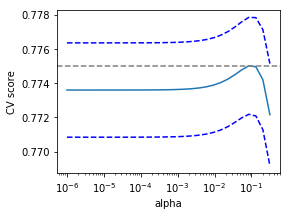

In [15]:
plt.figure(figsize=(4, 3))
plt.semilogx(alphas, scores)
# plot error lines showing +/- std. errors of the scores
plt.semilogx(alphas, np.array(scores) + np.array(scores_std) / np.sqrt(len(X_train)),
             'b--')
plt.semilogx(alphas, np.array(scores) - np.array(scores_std) / np.sqrt(len(X_train)),
             'b--')
plt.ylabel('CV score')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')

plt.show()

In [16]:
print(scores[np.argmax(scores)], '+/-', scores_std[np.argmax(scores)], 'alpha=', alphas[np.argmax(scores)])

0.7750073816187891 +/- 0.056891435316998654 alpha= 0.08531678524172796


In [17]:
regr = linear_model.Ridge(alpha=alphas[np.argmax(scores)])

In [18]:
regr.fit(X_train, y_train)

Ridge(alpha=0.08531678524172796, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

In [19]:
y_hat = regr.predict(X_test)

In [20]:
np.sqrt(mean_squared_error(y_test, y_hat)), r2_score(y_test, y_hat)

(4.30171656120793, 0.7476638381997108)

##### 5. задание про пайплайн

Используйте Pipeline из пакета sklearn.
сделайте поиск по параметрам (GridSearch), автоматически выберете какой способ нормировки признаков (минмакс скейлинг, стандарт скейлер) работает лучше, добавьте полиномиальных признаков, автоматически выберите модель (ридж лассо или просто регрессия) и регуляризацию к ней (если нужно).

In [24]:
pipeline = Pipeline(steps=[('scaler', StandardScaler()), 
                     ('poly', PolynomialFeatures(include_bias=False)),
                     ('regressor', LinearRegression(n_jobs=-1)),
                    ])

In [25]:
param_grid = [
    {
        'scaler': [MinMaxScaler(), StandardScaler()],
        'poly__degree': list(range(1,5)),
        'regressor': [LinearRegression()]
    },
    {
        'scaler': [MinMaxScaler(), StandardScaler()],
        'poly__degree': list(range(1,5)),
        'regressor': [Ridge(), Lasso()],
        'regressor__alpha': np.power(10.,np.arange(-3, 3)) 
    },
    {
        'scaler': [MinMaxScaler(), StandardScaler()],
        'poly__degree': list(range(1,5)),
        'regressor': [ElasticNet()],
        'regressor__alpha': np.power(10.,np.arange(-3, 3)) ,
        'regressor__l1_ratio': np.power(10.,np.arange(-3, 3)) 
    },
]

In [26]:
regr = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', n_jobs=multiprocessing.cpu_count() // 2)
regr.fit(X_train, y_train)

c:\users\oswalth\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
c:\users\oswalth\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:791: RuntimeWarning: invalid value encountered in subtract
  array_means[:, np.newaxis]) ** 2,
c:\users\oswalth\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('poly', PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)), ('regressor', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False))]),
       fit_params=None, iid='warn', n_jobs=3,
       param_grid=[{'scaler': [MinMaxScaler(copy=True, feature_range=(0, 1)), StandardScaler(copy=True, with_mean=True, with_std=True)], 'poly__degree': [1, 2, 3, 4], 'regressor': [LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)]}, {'scaler': [MinMaxScaler(copy=True..., 1.e+01, 1.e+02]), 'regressor__l1_ratio': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

> добейтесь качества по R2

- 0.811


In [27]:
regr.best_params_

{'poly__degree': 3,
 'regressor': ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True, l1_ratio=0.1,
       max_iter=1000, normalize=False, positive=False, precompute=False,
       random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
 'regressor__alpha': 0.001,
 'regressor__l1_ratio': 0.1,
 'scaler': MinMaxScaler(copy=True, feature_range=(0, 1))}

In [28]:
y_hat = regr.predict(X_test)

In [29]:
np.sqrt(mean_squared_error(y_test, y_hat)), r2_score(y_test, y_hat)

(3.312047495079347, 0.8504146637890013)